# Case study: 311 service requests.

Prompt: Please describe the steps you take to ingest and process the data, what are the challenges and how you overcome them.

Aggregate the 311 records in ways that best describes the characteristics of the inbound call patterns. Explain and visualize your findings. What are the implications you can infer from the patterns?


### Final goal of project:predict the daily 311 inbound calls for the next 7 days 

•	Use your insights from previous sections to build a predictive model of your choice – explain the assumptions of your model and why you picked it.

•	What features are you using in your model and, how does your data exploration process help you decide which features you are incorporating in your model?

•	Evaluate the impact of weather on the call volume, find patterns and define causal impact if there’s any. 

•	Build a reasonable model framework, explain your model results, and justify the relationships identified in the model. Not necessary to dig into complex models.


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Import data. Note that this takes a couple of minutes due to the large file size.

In [2]:
c_path = '311-2016-2018.csv'
c = pd.read_csv(c_path, low_memory=False)
# Could parse dates during input here. I've done so later instead.
c = pd.read_csv(c_path, parse_dates=['Created Date', 'Closed Date', 'Resolution Action Updated Date'],low_memory=False)

Get an initial impression of the table we are working with.

In [3]:
c.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Created Year
0,38237851,01/17/2018 02:39:00 PM,01/24/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11222,95 GREENPOINT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.730013,-73.956267,"(40.73001299919553, -73.95626650502489)",2018.0
1,38237852,01/17/2018 01:40:00 PM,01/21/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,10308,40 ASHWOOD COURT,...,NaN,NaN,NaN,NaN,NaN,NaN,40.558494,-74.141962,"(40.558494382393974, -74.14196245468202)",2018.0
2,38237855,01/17/2018 10:42:00 PM,01/20/2018 10:02:00 PM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11361,204-36 47 ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,40.754075,-73.775594,"(40.75407455058778, -73.77559379608053)",2018.0
3,38237856,01/17/2018 07:26:00 PM,01/19/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,10467,3851 BARNES AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.884181,-73.859111,"(40.88418051177941, -73.85911054646147)",2018.0
4,38237857,01/17/2018 07:13:00 PM,01/20/2018 07:41:00 PM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11215,160 7 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.672113,-73.977242,"(40.67211272839247, -73.97724198791173)",2018.0


Look at a single row to see what columns exist and what data types there are. Many entries are NaN, which is likely going to be true quite often.

Many of these variables probalby aren't that interesting for predicting how many calls there are or relating to weather.
Created Date is certainly of interest, and is what I will start with.

I could also group by Agency, Borough, Incident Zip, Location (as determined by latitude and longitude), Location type, or Complaint type (though there are a couple hundred different complaint types as I find below). I could certainly imagine complaint type or complaint agency changes with season and weather (garbage is stinky in the summer, snow complaints are only going to be in the winter, etc.)

In [118]:
c.iloc[0,:]

Unique Key                                                       38237851
Created Date                                          2018-01-17 14:39:00
Closed Date                                        01/24/2018 12:00:00 AM
Agency                                                               DSNY
Agency Name                                      Department of Sanitation
Complaint Type                        Request Large Bulky Item Collection
Descriptor                            Request Large Bulky Item Collection
Location Type                                                    Sidewalk
Incident Zip                                                        11222
Incident Address                                     95 GREENPOINT AVENUE
Street Name                                             GREENPOINT AVENUE
Cross Street 1                                            FRANKLIN STREET
Cross Street 2                                           MANHATTAN AVENUE
Intersection Street 1                 

In [120]:
#Create abidged dataframe for testing
c.loc[0:99].to_csv('311_abridged.csv', index=False)
cab = pd.read_csv('311_abridged.csv')

Convert date columns to datetime64 type for use in comparing dates.

In [6]:
c['Created Date'] = c['Created Date'].astype('datetime64')

# # Closed date should also be converted to datetime64 format, but I likely won't use it for anything.
#c['Closed Date'] = c['Closed Date'].astype('datetime64') 

Check that the datetime conversion is working correctly.

In [121]:
cab['Created Date']

0     01/17/2018 02:39:00 PM
1     01/17/2018 01:40:00 PM
2     01/17/2018 10:42:00 PM
3     01/17/2018 07:26:00 PM
4     01/17/2018 07:13:00 PM
               ...          
95    01/17/2018 07:13:09 AM
96    01/17/2018 05:20:44 PM
97    01/17/2018 09:32:00 AM
98    01/17/2018 10:21:51 AM
99    01/17/2018 09:27:38 PM
Name: Created Date, Length: 100, dtype: object

In [122]:
c.loc[0:99,'Created Date']

0    2018-01-17 14:39:00
1    2018-01-17 13:40:00
2    2018-01-17 22:42:00
3    2018-01-17 19:26:00
4    2018-01-17 19:13:00
             ...        
95   2018-01-17 07:13:09
96   2018-01-17 17:20:44
97   2018-01-17 09:32:00
98   2018-01-17 10:21:51
99   2018-01-17 21:27:38
Name: Created Date, Length: 100, dtype: datetime64[ns]

In [10]:
cab.dtypes

Unique Key                                 int64
Created Date                      datetime64[ns]
Closed Date                               object
Agency                                    object
Agency Name                               object
Complaint Type                            object
Descriptor                                object
Location Type                             object
Incident Zip                             float64
Incident Address                          object
Street Name                               object
Cross Street 1                            object
Cross Street 2                            object
Intersection Street 1                     object
Intersection Street 2                     object
Address Type                              object
City                                      object
Landmark                                 float64
Facility Type                             object
Status                                    object
Due Date            

In [11]:
c.loc[:20, ['Created Date', 'Closed Date', 'Agency Name', 'Complaint Type']]

,Created Date,Closed Date,Agency Name,Complaint Type
0,2018-01-17 14:39:00,01/24/2018 12:00:00 AM,Department of Sanitation,Request Large Bulky Item Collection
1,2018-01-17 13:40:00,01/21/2018 12:00:00 AM,Department of Sanitation,Request Large Bulky Item Collection
2,2018-01-17 22:42:00,01/20/2018 10:02:00 PM,Department of Sanitation,Request Large Bulky Item Collection
3,2018-01-17 19:26:00,01/19/2018 12:00:00 AM,Department of Sanitation,Request Large Bulky Item Collection
4,2018-01-17 19:13:00,01/20/2018 07:41:00 PM,Department of Sanitation,Request Large Bulky Item Collection
5,2018-01-17 18:58:00,01/18/2018 10:00:00 PM,Department of Sanitation,Request Large Bulky Item Collection
6,2018-01-17 17:01:00,01/21/2018 12:00:00 AM,Department of Sanitation,Request Large Bulky Item Collection
7,2018-01-17 15:28:00,01/21/2018 12:00:00 AM,Department of Sanitation,Request Large Bulky Item Collection
8,2018-01-17 14:30:00,01/23/2018 12:00:00 AM,Department of Sanitation,Request Large Bulky Item Collection
9,2018-01-17 14:29:00,01/19/2018 08:34:00 PM,Department of Sanitation,Request Large Bulky Item Collection


Explore different complaint types that exist.

In [12]:
c.loc[100:125,'Complaint Type']

100              Noise - Residential
101              Noise - Residential
102              Noise - Residential
103              Noise - Residential
104              Noise - Residential
105              Noise - Residential
106                            Noise
107      Non-Emergency Police Matter
108                      Air Quality
109                             Lead
110                             Lead
111                     Water System
112                    Drug Activity
113                            Noise
114                            Noise
115                 Street Condition
116                            Noise
117             Sanitation Condition
118             Sanitation Condition
119                            Sewer
120                            Sewer
121    Root/Sewer/Sidewalk Condition
122          Overgrown Tree/Branches
123               Water Conservation
124               Water Conservation
125               Consumer Complaint
Name: Complaint Type, dtype: object

In [13]:
complaint_types = np.unique(c.loc[:,'Complaint Type'])
print(complaint_types)
print('Number of unique complaint types: ' , len(complaint_types))

['AGENCY' 'APPLIANCE' 'ATF' 'Abandoned Vehicle' 'Adopt-A-Basket'
 'Advocate - Levy' 'Advocate - Lien' 'Advocate - Other' 'Advocate - RPIE'
 'Advocate-Business Tax' 'Advocate-Co-opCondo Abatement'
 'Advocate-Commercial Exemptions' 'Advocate-Personal Exemptions'
 'Advocate-Prop Class Incorrect' 'Advocate-Prop Refunds/Credits'
 'Advocate-Property Value' 'Advocate-SCRIE/DRIE' 'Advocate-UBT'
 'Air Quality' "Alzheimer's Care" 'Animal Abuse'
 'Animal Facility - No Permit' 'Animal in a Park' 'Animal-Abuse'
 'Asbestos' 'Asbestos/Garbage Nuisance' 'BEST/Site Safety'
 'Beach/Pool/Sauna Complaint' 'Benefit Card Replacement'
 'Bereavement Support Group' 'Bike Rack Condition'
 'Bike/Roller/Skate Chronic' 'Blocked Driveway' 'Boilers' 'Borough Office'
 'Bottled Water' 'Bridge Condition' 'Broken Muni Meter'
 'Broken Parking Meter' 'Building Condition' 'Building Marshals office'
 'Building/Use' 'Bus Stop Shelter Complaint' 'Bus Stop Shelter Placement'
 'Calorie Labeling' 'Case Management Agency Complain

Check extent of locations (latitude and longitude). Appears to be only NYC (which is different from the weather, which has weather from all over the state).

In [14]:
print(np.min(c.loc[:,'Latitude']))
print(np.max(c.loc[:,'Latitude']))
print(np.min(c.loc[:,'Longitude']))
print(np.max(c.loc[:,'Longitude']))

40.49804421521046
40.91294056699566
-74.25521082506387
-73.70038354802529


### Analysis of daily service request counts

Explore frequency of complaints over time. (Using Created Date)

In [106]:
# Select all service requests on an individual day.
c.loc[(c['Created Date'] > np.datetime64('2016-08-12')) & (c['Created Date'] < np.datetime64('2016-08-13'))]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Created Year
1945100,40795136,2016-08-12 13:28:01,08/14/2016 12:00:00 AM,DOB,Department of Buildings,General Construction/Plumbing,Adjacent Buildings Not Protected,NaN,11206,59 MONTROSE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.706918,-73.947578,"(40.70691770450116, -73.94757838386167)",2016.0
1946039,40816705,2016-08-12 11:40:17,08/16/2016 12:00:00 AM,DOB,Department of Buildings,General Construction/Plumbing,Adjacent Buildings Not Protected,NaN,11233,586 BAINBRIDGE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.682985,-73.913449,"(40.68298467109504, -73.91344919536284)",2016.0
2292474,42376770,2016-08-12 15:21:31,07/16/2019 12:00:00 AM,DOB,Department of Buildings,Miscellaneous Categories,Inspection Work Order (DOB),NaN,10025,145 WEST 96 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.793421,-73.968840,"(40.79342065232442, -73.9688398667975)",2016.0
2294013,42533874,2016-08-12 07:57:53,08/15/2016 12:00:00 AM,DOB,Department of Buildings,General Construction/Plumbing,Building Permit - None,NaN,11436,123-14 147 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.675379,-73.791408,"(40.675378818722095, -73.79140752497212)",2016.0
2296295,42542955,2016-08-12 13:37:13,08/12/2016 01:37:13 PM,DOB,Department of Buildings,BEST/Site Safety,Demolition Notification Received,NaN,11355,41-14 HAIGHT STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.755505,-73.834387,"(40.75550528692892, -73.83438717963556)",2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4530988,34103272,2016-08-12 06:11:57,08/15/2016 11:00:00 AM,DOT,Department of Transportation,Street Condition,Pothole,NaN,10475,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,40.885991,-73.827914,"(40.88599088210431, -73.82791398812846)",2016.0
4531836,34104401,2016-08-12 06:27:50,08/15/2016 01:08:00 PM,DOT,Department of Transportation,Street Condition,Pothole,NaN,10455,880 EAST 147 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.810326,-73.904325,"(40.810325615052456, -73.9043247693361)",2016.0
4532649,34105510,2016-08-12 06:14:10,08/15/2016 02:00:00 PM,DOT,Department of Transportation,Street Condition,Pothole,NaN,10473,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,40.821756,-73.860193,"(40.82175623322948, -73.86019294631032)",2016.0
4564904,34147629,2016-08-12 12:49:34,08/22/2016 12:00:00 AM,DOB,Department of Buildings,General Construction/Plumbing,Sidewalk Shed/Pipe Scafford - Inadequate Defec...,NaN,11222,148 WEST STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.732100,-73.959624,"(40.732100239554605, -73.95962435981285)",2016.0


In [107]:
# Check which date range is present
print('Min Date: ', np.min(c['Created Date']))
print('Max Date: ', np.max(c['Created Date']))

Min Date:  2016-01-01 00:00:00
Max Date:  2018-12-31 23:59:56


Build a dataframe to store all dates and the nubmer of service requests for each date.

In [17]:
dates = np.arange(np.datetime64('2016-01-01'), np.datetime64('2019-01-01'), np.timedelta64(1, 'D'))

In [18]:
dict311 = {'Date': dates, 'call_count': np.full(len(dates), np.nan, dtype='float64')}

d311 = pd.DataFrame(data = dict311)

In [19]:
d311

,Date,call_count
0,2016-01-01,NaN
1,2016-01-02,NaN
2,2016-01-03,NaN
3,2016-01-04,NaN
4,2016-01-05,NaN
...,...,...
1091,2018-12-27,NaN
1092,2018-12-28,NaN
1093,2018-12-29,NaN
1094,2018-12-30,NaN


Loop through dates and count nubmer of 311 requests each day.

Note: I could easily expand this loop to count number of requests in each borough, or nubmer requests to each department, or nubmer of requests of each type. I may do so later to expand this analysis.

In [20]:
for i in range(len(d311)-1):
    temp = c.loc[(c['Created Date'] > d311.loc[i,'Date']) & (c['Created Date'] < d311.loc[(i+1),'Date'])]
    d311.loc[i, 'call_count'] = len(temp)
    
# Last date is slightly weird since dates list doesn't have the date+1. Do it independently.
d311.loc[len(d311)-1, 'call_count'] = len(c.loc[(c['Created Date'] > d311.loc[len(d311)-1,'Date']) 
                                          & (c['Created Date'] < np.datetime64('2019-01-01'))])

In [21]:
d311

,Date,call_count
0,2016-01-01,4260.0
1,2016-01-02,4505.0
2,2016-01-03,4749.0
3,2016-01-04,8900.0
4,2016-01-05,11936.0
...,...,...
1091,2018-12-27,7019.0
1092,2018-12-28,6923.0
1093,2018-12-29,5153.0
1094,2018-12-30,5112.0


In [110]:
# Save dataframe of call counts for each date to file.
d311.to_csv('311_daily_counts.csv', index=False)

### Plotting daily call counts over time

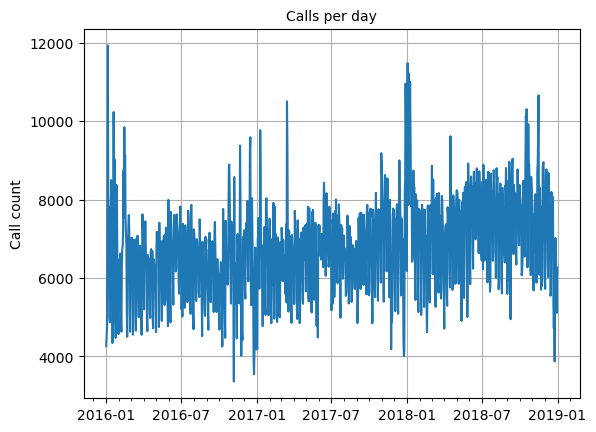

In [23]:
fig, ax = plt.subplots()
# common to all three:
ax.plot('Date', 'call_count', data=d311)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_title('Calls per day', fontsize='medium')
plt.show()

### Initial interpretation -- 311 requests

There appears to be variation over days, seasonal variation, some peak times (after New Years in 2016 and 2018), and possibly a general increasing trend over time.

Expected calls per day matches with numbers we are seeing (about 7000).

In [29]:
print('Total calls: ', len(c))
print('Number of days: ', len(d311))
print('Average calls per day: ', len(c)/len(d311))

Total calls:  7631721
Number of days:  1096
Average calls per day:  6963.249087591241


Lets look at a couple of weeks to see daily variation. Here I have plotted call counts over two weeks in April 2016, with the Monday dates labeled. It appears that 311 calls drop of noiticeably on weekends (Saturdays and Sundays).

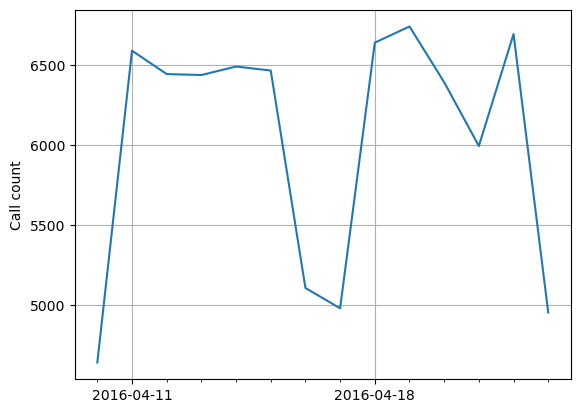

In [58]:
fig, ax = plt.subplots()
# common to all three:
ax.plot(d311.loc[100:113,'Date'], d311.loc[100:113,'call_count'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0)) # Zero selects mcondays for major labels
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=range(1,8)))

ax.grid(True)
ax.set_ylabel(r'Call count')
# ax.set_title('Calls per day', fontsize='medium')
plt.show()

Selecting a few random weeks in December 2017 shows a similar trend with fewer calls on weekends.

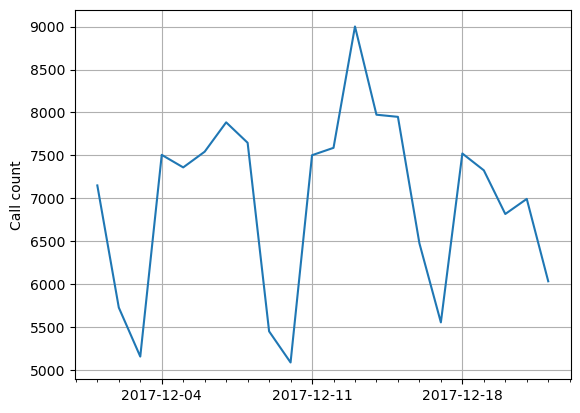

In [63]:
fig, ax = plt.subplots()
# common to all three:
ax.plot(d311.loc[700:721,'Date'], d311.loc[700:721,'call_count'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0)) # Zero selects mcondays for major labels
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=range(1,8)))

ax.grid(True)
ax.set_ylabel(r'Call count')
# ax.set_title('Calls per day', fontsize='medium')
plt.show()

### Probability distribution

Look at histogram of call numbers. The distributiokn looks relatively close to normal, but has a long tail towards high numbers of requests. This histogram fits with what we see in the daily 311 request totals plotted over time (which shows some large peaks).

I could consider either neglecting outliers in my prediction for the next 7 days or otherwise accounting for the possibility of large spikes in 311 requests.

C:\Users\erics\AppData\Local\Temp\ipykernel_25360\3614825516.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


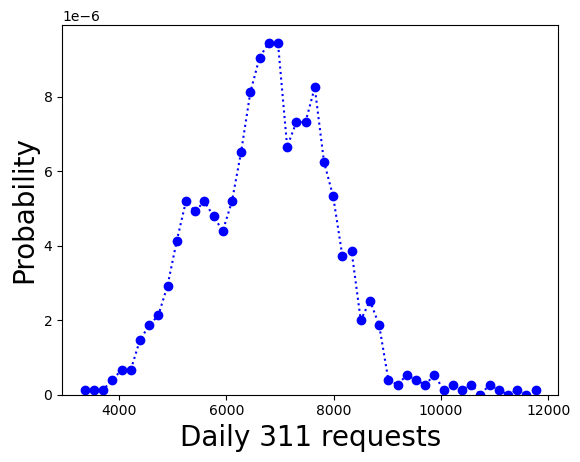

In [68]:
# Make histogram of number of call numbers
h_311, bins_x_space = np.histogram(d311['call_count'], bins=50)

# plot histogram with probability
fig1, ax1 = plt.subplots()
ax1.plot(bins_x_space[:-1],h_311/float(np.sum(d311['call_count'])), 'b:o')
# ax1.set_xlim([0, 12])
ax1.set_ylim(bottom=0)
ax1.set_xlabel(r'Daily 311 requests', fontsize = 20)
ax1.set_ylabel(r'Probability', fontsize = 20)
#plt.legend()
fig1.show()

### Linear regression for service requests over time

Service requests appear to increase over time. Let's check if that is true using a simple linear regression.

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
# Make an array of call counts
y = d311['call_count'].to_numpy()

In [85]:
y

array([4260., 4505., 4749., ..., 5153., 5112., 6270.])

In [89]:
# Define an array for time. This is just days since the beginning of 2016.
x = np.arange(len(y)).reshape((-1,1))

In [90]:
x

array([[   0],
       [   1],
       [   2],
       ...,
       [1093],
       [1094],
       [1095]])

In [91]:
# model = LinearRegression()
# model.fit(x, y)
model = LinearRegression().fit(x, y)

In [117]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.10860351178365502
intercept: 6158.4556637545
slope: [1.26386793]


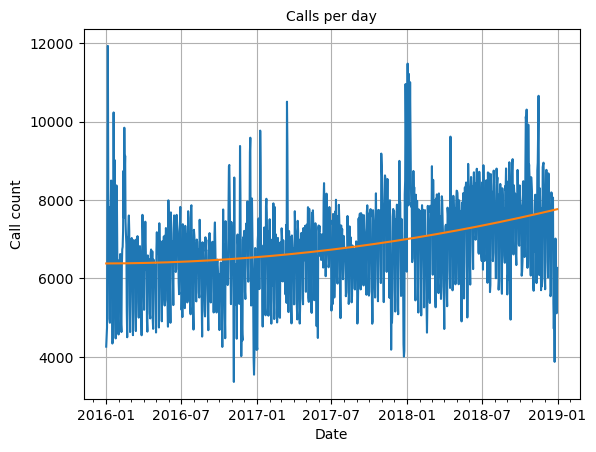

In [137]:
fig, ax = plt.subplots()
# common to all three:
# ax.plot(np.arange(len(d311)), 'call_count', data=d311)
# ax.plot(np.arange(len(d311)), np.arange(len(d311))*model.coef_[0] + model.intercept_)
ax.plot('Date', 'call_count', data=d311)
ax.plot(d311['Date'], model.predict(x))
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
# ax.set_xlabel(r'Days (since beginning of 2016)')
ax.set_xlabel(r'Date')
ax.set_ylabel(r'Call count')
ax.set_title('Calls per day', fontsize='medium')
plt.show()

While this fit doesn't capture any short-term variation, it does appear 311 requests increase over time in this dataset. I should include this variation in any modelling that I do.

Check: Should polynomial terms be included?

In [130]:
# Define an array for time. This is just days since the beginning of 2016.
x = np.arange(len(y)).reshape((-1,1))
# Add a column for x**2
x = np.hstack((x, x**2))
x

array([[      0,       0],
       [      1,       1],
       [      2,       4],
       ...,
       [   1093, 1194649],
       [   1094, 1196836],
       [   1095, 1199025]])

In [131]:
# model = LinearRegression()
# model.fit(x, y)
model = LinearRegression().fit(x, y)

In [132]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.11554895736036197
intercept: 6383.955279712999
slope: [0.02712415 0.00112945]


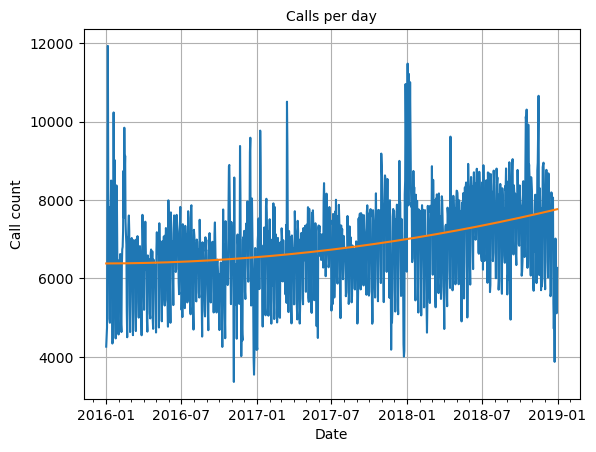

In [138]:
fig, ax = plt.subplots()
# common to all three:
# ax.plot(np.arange(len(d311)), 'call_count', data=d311)
# ax.plot(np.arange(len(d311)), np.arange(len(d311))*model.coef_[0] + model.intercept_)
ax.plot('Date', 'call_count', data=d311)
ax.plot(d311['Date'], model.predict(x))
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
# ax.set_xlabel(r'Days (since beginning of 2016)')
ax.set_xlabel(r'Date')
ax.set_ylabel(r'Call count')
ax.set_title('Calls per day', fontsize='medium')
plt.show()

A polynomial term improves the fit a bit (R^2 is higher) and could be considered for modeling.